In [11]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.datasets, sklearn.model_selection
import timeit
from progressbar import progressbar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook, we will be dealing with multiclass classification. We will have finally model, that can distinguish between all the numbers from the MNIST dataset and we will not need to deal with 4 and 9 only. The proper way of handling this problem is to use *softmax* function. I will show different approaches before, so we can compare them.

Firstly, we need the data. The template is still the same, so I will not describe it anymore.

In [5]:
data, target = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
data = data.reshape(-1, 784)
data[data < 128] = 0
data[data > 0] = 1
data = np.hstack([data, np.ones((data.shape[0],1))])
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target.astype(int), test_size=0.3, random_state=47)

# Perceptron

If you remember, we dealt with this problem in one of the previous notebook, when we were talking about perceptron algorithm. Just as a reminder, let's do it once again here, co we may compare the reults. I moved it into separate class, so I dont need to copy-paste it here once again. If you are interested, it is in the [src/perceptron.py](src/perceptron.py) file.

In [2]:
from src.perceptron_05 import multiclass_perceptron

train_acc, test_acc = multiclass_perceptron(train_data, train_target, test_data, test_target, iters=500, random_state=42)

print(f"Train accuracy: {train_acc}, Test accuracy: {test_acc}")

NameError: name 'train_data' is not defined

In [16]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
one_or_seven_indices = np.logical_or(y == 4, y == 9)
data = X[one_or_seven_indices].reshape(-1, 784)
data[data < 128] = 0
data[data > 0] = 1
data = np.hstack([data, np.ones((data.shape[0],1))])
target = y[one_or_seven_indices].reshape(-1)
target[target==4] = 0
target[target==9] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.3, random_state=47)

In [45]:
class MSELoss:
    def __call__(self, target, predicted):
        return np.sum((target - predicted) ** 2, axis=0)
    def gradient(self, target, predicted):
        return -(target - predicted)
    
class NLLLoss:
    def __call__(self, target, predicted):
        return np.sum(-target * np.log(predicted + 1e-15) - (1 - target) * np.log(1 - predicted + 1e-15), axis=0)
    def gradient(self, target, predicted):
        return - target / (predicted + 1e-15) + (1 - target) / (1 - predicted + 1e-15)
    
class AccuracyMetric:
    def __init__(self, name=None):
        self.name = name or "accuracy"
        self.correct = 0
        self.num = 0
    def __call__(self, target, predicted):
        self.correct += np.sum((predicted >= 0.5) & (target == 1)) + np.sum((predicted < 0.5) & (target == 0))
        self.num += len(target)
    def summary(self):
        acc = self.correct / self.num
        self.correct = 0
        self.num = 0
        return acc

In [48]:
from src.neuron_05 import Neuron

mse = Neuron(loss=MSELoss(), metrices=[AccuracyMetric()], epochs=500, learning_rate=0.001, batch_size=128, random_state=42)
mse_result = mse.fit(train_data, train_target, test_data, test_target, progress=True)

100% (500 of 500) |######################| Elapsed Time: 0:01:19 Time:  0:01:19


In [49]:
from src.neuron_05 import Neuron

nll = Neuron(loss=NLLLoss(), metrices=[AccuracyMetric()], epochs=500, learning_rate=0.001, batch_size=128, random_state=42)
nll_result = nll.fit(train_data, train_target, test_data, test_target, progress=True)

100% (500 of 500) |######################| Elapsed Time: 0:01:39 Time:  0:01:39


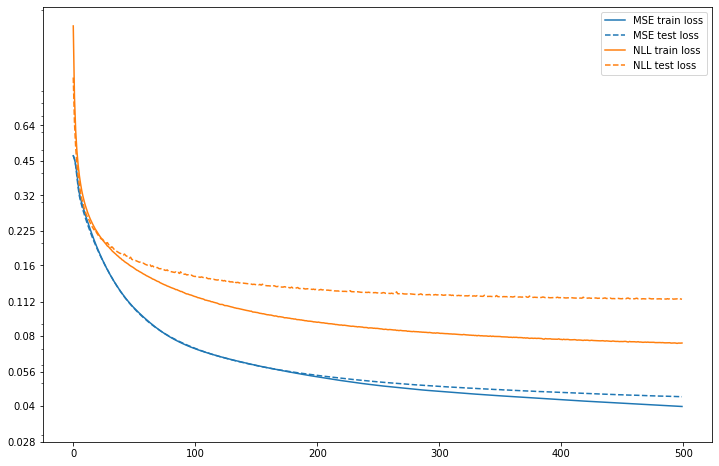

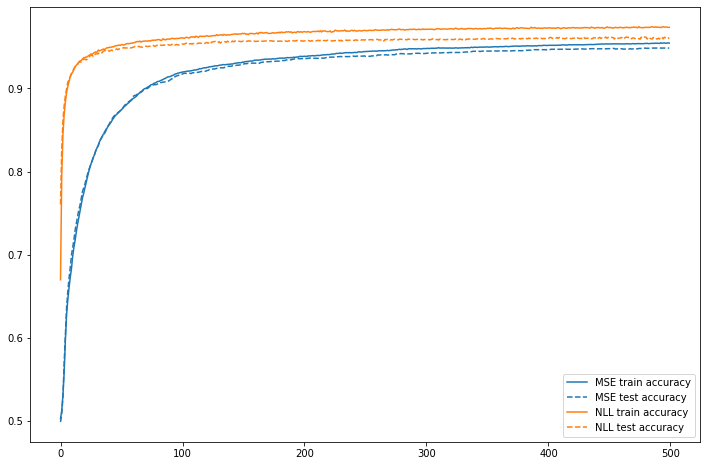

In [50]:
plt.figure(figsize=(12,8))
plt.plot(mse_result['train_loss'], label="MSE train loss", color='tab:blue')
plt.plot(mse_result['test_loss'], label="MSE test loss", color='tab:blue', linestyle='--')
plt.plot(nll_result['train_loss'], label="NLL train loss", color='tab:orange')
plt.plot(nll_result['test_loss'], label="NLL test loss", color='tab:orange', linestyle='--')
plt.yscale('log')
ticks = [0.028, 0.04, 0.056, 0.08, 0.112, 0.16, 0.225, 0.32, 0.45, 0.64]
plt.yticks(ticks=ticks, labels=ticks)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(mse_result['train_accuracy'], label="MSE train accuracy", color='tab:blue')
plt.plot(mse_result['test_accuracy'], label="MSE test accuracy", color='tab:blue', linestyle='--')
plt.plot(nll_result['train_accuracy'], label="NLL train accuracy", color='tab:orange')
plt.plot(nll_result['test_accuracy'], label="NLL test accuracy", color='tab:orange', linestyle='--')
plt.legend()
plt.show()